<p style="font-family:helvetica;grey:blue;font-size:18px;line-height: 1.4em;text-align:center;">
    </b></span><br>
    <span style="color:grey;font-size:32px"><b><u>UC3M Master in Big Data Analytics</u> </b></span><br>
    </b></span><br>
    <span style="color:grey"><b>Optimization for large-scale Data</b></span><br>
    </b></span><br>
    <span style="color:grey"><b>Assignment 2</b></span><br>
    </b></span><br>
    <span style="color:grey;font-size:15px"><b>Jose Antonio Jijon Vorbeck - 100438045</b></span>
</p>

Imports

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from numpy.random import randint
from numpy.linalg import inv
import time

from sklearn import metrics

from scipy.optimize import minimize
from numpy import linalg as LA

import matplotlib.pyplot as plt 

First we start by generating the random data.

In [2]:
# K = 100 
n_pred = 100

# 1000 observations
n_obs = 1000

# generate random beta coefficients between (-5,5) 100 in total
betas = randint(-5,5,size=([n_pred+1,1]))

# generate the matrix X using random numbers

X0_s = np.ones([n_obs,1]) # coefficients of beta_0
X1_s = np.random.uniform(-10,10,[n_obs, n_pred]) # rest of the X matrix size(n_obs, n_pred)
X = np.concatenate([X0_s, X1_s], axis = 1) # put together X_0s and X_1s


# The errors must be normally distriuted around 0
error = np.random.normal(0,1,(n_obs,1))

# now we can compute the Y_s
Y = np.dot(X,betas) + error
print('First 5 coeffs of betas')
betas[:5]

First 5 coeffs of betas


array([[ 2],
       [ 1],
       [ 2],
       [-5],
       [-5]])

The goal of the assignment is to adjust a multiple linear regression model to explain variable $Y$ in terms of the other variables $X$, having

$Y = \beta'X + \epsilon$ where $\beta = (\beta_0, \beta_1, ... \beta_K )$

By using the *Ridge regression*

\begin{align*}
  \text{minimize}_\beta \quad  \| y - X\beta \|_2^2 + \rho \| \beta \|_2^2
\end{align*}

We can consider $\rho$ to be a fixed parameter, e.g., $\rho= 1$

### <u> Questions </u>

### a.) Estimate the value of the regression coefficients by implementing the analytical solution.

The analytical solution of the normal linear regression is given by: 

$\beta_{ls}=(X^T X)^{-1}X^T y$

In the Ridge regression, the equation in matrix form is the following: 

$(Y - X\beta)^T(Y - X\beta) + \rho\beta^T\beta$

So, by taking its derivative and deriving with respect to $\beta$:

$X^TY = (X^TX + \rho I)\beta$

And we get to the analytical solution of the Ridge equation:

$\beta = (X^TX + \rho I)^{-1}X^TY$





In [3]:
# We set rho to be fixed at 1
rho = 1
start = time.time()
beta_analytical = np.dot(np.dot(inv(np.dot(X.T,X) + rho*np.identity(n_pred+1)),X.T),Y)
time_analytic = round(time.time() - start,5)
print(f'Time elapsed: {time_analytic}')
print(f'Absolute mean error from true betas: {round(np.mean(np.abs(beta_analytical-betas)),5)}')
print('Values of first 5 coeff. analytically calculated:')
beta_analytical[:5]

Time elapsed: 0.01073
Absolute mean error from true betas: 0.0058
Values of first 5 coeff. analytically calculated:


array([[ 2.06249336],
       [ 1.01259877],
       [ 2.00723955],
       [-5.00696314],
       [-5.00186935]])

In [4]:
# create a function to compute future errors:
def error_value(beta_reg):
    return LA.norm(beta_analytical.T-beta_reg,ord=2) / LA.norm(beta_analytical.T,ord=2)

### b.) Estimate the value of the regression coefficients by using the function minimize from the Python module Scipy.optimize. Try at least four available solvers and compare their performance in terms of number of iterations, number of function, gradient and hessian evaluations as well as total computational time.

The objective function is simply given by minimizing the following function: 

$\| y - X\beta \|_2^2 + \rho \| \beta \|_2^2$

For the computation of the Gradient, we need to apply the first derivative with respect to $\beta$

We will write, for simplicity, in scalar notation: <br>
$(y - x\beta)^2 + \rho\beta^2$

Deriving this w.r.t. $\beta$ we get the following: 

$-2(y - x\beta)x + 2\rho\beta$ (1), which simpplifies to: 

$-2yx + 2x^2\beta + 2\rho\beta$, deriving this again w.r.t. $\beta$ 

$2x^2 + 2\rho$

So, in matrix notation we are left with the following: 

**Gradient:**   <br> $-2(Y - X\beta)X + 2\rho\beta$  
**Hessian:**  <br>  $2X^TX + 2\rho I$


#### Definition of the Functions:

Here I will define the functions for use in the rest of the report.

In [5]:
# define the objective function: 
def least_sq_ridge(beta_ls, X, Y, rho):
    beta_ls = np.matrix(beta_ls)
    z = Y - np.dot(X,beta_ls.T)
    f = np.dot(z.T,z) + rho * LA.norm(beta_ls)
    return f

# function for the jacobian (gradient) matrix
def gradient(beta_ls, X, Y, rho):
    beta_ls = np.matrix(beta_ls)
    z = Y - np.dot(X,beta_ls.T)
    gr = -2*np.dot(z.T,X) + 2*rho*beta_ls 
    aa = np.squeeze(np.asarray(gr))
    return aa

# function for the hessian matrix
def hessian(beta_ls, X, Y, rho):
    beta_ls = np.matrix(beta_ls)
    hes = 2*np.dot(X.T,X) + 2*rho*np.identity(n_pred+1)
    return np.squeeze(np.asarray(hes))

# coordinate gradient function
def gradient_coord(beta_ls, index, X, Y, rho):
    beta_ls = np.matrix(beta_ls)
    pp = -2*np.dot((Y-np.dot(X,beta_ls.T)).T,X[:,index]) + 2*rho*beta_ls[:,index]
    aa = np.zeros(b)
    aa[index]=pp
    return aa

# initiate all coeff. to zero
beta_0 = np.zeros(n_pred+1)

Now we will apply the minimization function with 5 different solvers.<br>
The solutions and summary table of each will be presented in a table below.

In [6]:
# Nelder_Mead
start = time.time()
reg_Nelder_Mead = minimize(least_sq_ridge, beta_0, args=(X, Y, rho), method='Nelder-Mead', options={'disp': True,'xtol': 1e-10})
Nelder_Mead_time = time.time() - start 

In [7]:
Nelder_Mead_sum = {'time': Nelder_Mead_time, 'error': error_value(reg_Nelder_Mead.x), 'iterations': reg_Nelder_Mead.nit,
                  'function evals': reg_Nelder_Mead.nfev}

In [8]:
# Powell
start = time.time()
reg_Powell = minimize(least_sq_ridge, beta_0, args=(X, Y, rho), method='Powell', options={'disp': True,'xtol': 1e-10})
Powell_time = time.time() - start

Optimization terminated successfully.
         Current function value: 858.716329
         Iterations: 8
         Function evaluations: 15036


In [9]:
Powell_sum = {'time': Powell_time, 'error': error_value(reg_Powell.x), 'iterations': reg_Powell.nit,
                  'function evals': reg_Powell.nfev}

In [10]:
# COBYLA
start = time.time()
reg_COBYLA = minimize(least_sq_ridge, beta_0, args=(X, Y, rho), method='COBYLA', options={'disp': True})
COBYLA_time = time.time() - start

In [11]:
COBYLA_sum = {'time': COBYLA_time, 'error': error_value(reg_COBYLA.x),
                  'function evals': reg_COBYLA.nfev}

In [12]:
# TNC
start = time.time()
reg_TNC = minimize(least_sq_ridge, beta_0, args=(X, Y, rho), method='TNC', options={'disp': True})
TNC_time = time.time() - start

In [13]:
TNC_sum = {'time': TNC_time, 'error': error_value(reg_TNC.x), 'iterations': reg_TNC.nit,
                  'function evals': reg_TNC.nfev}

In [14]:
# Newton-CG
start = time.time()
reg_Newton_CG = minimize(least_sq_ridge, beta_0, args=(X, Y, rho), hess = hessian, jac = gradient, method='Newton-CG', options={'disp': True})
Newton_CG_time = time.time() - start

Optimization terminated successfully.
         Current function value: 858.746341
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 22
         Hessian evaluations: 11


In [15]:
Newton_CG_sum = {'time': Newton_CG_time, 'error': error_value(reg_Newton_CG.x), 'iterations': reg_Newton_CG.nit,
                  'function evals': reg_Newton_CG.nfev, 'gradient evals': reg_Newton_CG.njev, 'hessian evals': reg_Newton_CG.nhev }

In [16]:
# BFGS
start = time.time()
reg_BFGS = minimize(least_sq_ridge, beta_0, args=(X, Y, rho), jac = gradient, method='BFGS', options={'disp': True})
BFGS_time = time.time() - start

Optimization terminated successfully.
         Current function value: 858.745562
         Iterations: 118
         Function evaluations: 220
         Gradient evaluations: 220


In [17]:
BFGS_sum = {'time': BFGS_time, 'error': error_value(reg_BFGS.x), 'iterations': reg_BFGS.nit,
                  'function evals': reg_BFGS.nfev, 'gradient evals': reg_BFGS.njev}

**Summary Table**

In [18]:
# summary of solvers b.)
Summary_b = {'Nelder_Mead': Nelder_Mead_sum, 'Powell': Powell_sum, 'Cobyla': COBYLA_sum, 'TNC': TNC_sum,
             'Newton_CG': Newton_CG_sum, 'BFGS': BFGS_sum}
pd.DataFrame.from_dict(Summary_b).round(3)

,Nelder_Mead,Powell,Cobyla,TNC,Newton_CG,BFGS
time,3.87,3.225,0.964,5.796,0.02,0.095
error,0.79,0.000,0.052,0.000,0.00,0.000
iterations,19527.00,8.000,NaN,57.000,11.00,118.000
function evals,20200.00,15036.000,1000.000,595.000,12.00,220.000
gradient evals,NaN,NaN,NaN,NaN,22.00,220.000
hessian evals,NaN,NaN,NaN,NaN,11.00,NaN


As we can see above, the two last methods, for which the jacobian or the hessian matrices are used, converge faster and need less itertions. In fact, the Nelder-Mead needs much more iterations, and the TNC solver requires  way more time to deliver a solution, while the Newton one does it in less than 0.05sec. 

We see that the errors are also very small for the Newton-CG and the BFGS solvers, compared to the analytical solution obtained in part a.). 

### c.) Estimate the value of the regression coefficients by implementing the following:
* Gradient Method
* Newton's Method
* Quasi-Newton Method

*Consider a line search technique to improve the algorithm convergence, e.x., Armijo rule. Compare the performance of these algorithms (number of iterations and total computational time).*

First we calculate the objective funtion value from the analytically calculated $\beta$

In [19]:
# objetive function from the analytical beta's
print(f'Objetive function from the analytical beta --> {least_sq_ridge(beta_analytical.T, X, Y, rho)}')

Objetive function from the analytical beta --> [[858.745562]]


**Gradient Method**

In a few words, this method evaluates the function at an initial given point, and with the help of the negative gradient of the function ($-\nabla f$) the solver will choose the descent direction, and then move the point to obtain the value until we get to a minimum value, where $\nabla f --> 0 $ .

It is the simplest method and with the least computational cost, but in practice it converges in too many iterations.

The mathematical representation of the gradient method is the following: 

$x_{k+1} = x_{k} -\nabla f(x_k) * \alpha_k$

Where alpha is the step length, that can also be adjusted at every iteration $k$

In [20]:
# size od the X matrix
(a,b) = X.shape

# parameters of the algorithm
n_iter = 4000 # max number of iterations
alpha = 1e-7 # fixed value of alpha
eps = 1e-3 # smallest difference
tol = 10000 # initial tolerance

# initialize the values at 0
beta_grad = np.zeros(b)
obj_G = np.zeros(n_iter)
tol_iterG = np.zeros(n_iter)
alpha_k = np.zeros(n_iter)

k = 0
rho = 1
start = time.time()
while (tol > eps) and (k <= n_iter-2):
    k = k + 1
    grad = gradient(beta_grad, X, Y, rho)
    
    ############### adjusting alpha with the armijo rule
    sigma = 0.01
    beta= 0.1
    alpha=1e-5
    while (least_sq_ridge(beta_grad - grad * alpha, X,Y,rho) > least_sq_ridge(beta_grad, X,Y,rho)+alpha*sigma*np.dot(grad,-grad.T)):
        alpha = alpha*beta
    ################
    
    beta_grad = beta_grad - grad * alpha
    tol = LA.norm(grad,ord=2)
    obj_G[k] = least_sq_ridge(beta_grad, X, Y, rho)
    tol_iterG[k] = tol
    alpha_k[k] = alpha

gradient_time = time.time()-start
gradient_iterations = k

In [21]:
gradient_sum = {'time': gradient_time, 'iterations':gradient_iterations, 'error': error_value(beta_grad),
                'objective function':obj_G[k], "last iteration's tol": tol_iterG[k]  }
gradient_sum

{'time': 0.25242090225219727,
 'iterations': 843,
 'error': 1.852309131998861e-08,
 'objective function': 858.7455644066168,
 "last iteration's tol": 0.0009997904113138805}

**Newton's Method**

Netwon's method is a modification of the gradient method, with the addition of the second derivative term of the function, or in matrix representation, what we know as the hessian matrix. 

It is known to converge very fast and with less iterations than the gradient method, but due to the computation of the gradient and hessian matrices, it can be very computationally costly. It converges always whenever $\nabla^2f(x_k)$ is not singular.

The mathematical representation of this method is the following: 

$x_{k+1} = x_{x} - \frac{\nabla f(x_k)}{\nabla^2 f(x_k)} \alpha_k$  

$\rightarrow$ whenever $\nabla^2 f(x_k)$ is non-singular

In [22]:
# size od the X matrix
(a,b) = X.shape

# parameters of the algorithm
n_iter = 4000 # max number of iterations
alpha = 1e-7 # starting value of alpha
eps = 1e-3 # smallest difference
tol = 10000 # initial tolerance
sigma = 0.1
beta= 0.1


# initialize the values at 0
beta_newt = np.zeros(b)
obj_N = np.zeros(n_iter)
tol_iterN = np.zeros(n_iter)
alpha_k = np.zeros(n_iter)

k = 0
rho = 1
start = time.time()

while (tol > eps) and (k <= n_iter-2):
    k = k + 1
    grad = gradient(beta_newt, X, Y, rho)
    hess = hessian(beta_newt, X, Y, rho)
    p_k = -np.dot(np.linalg.inv(hess),grad)
    alpha=1
    ################ adjusting alpha with the armijo rule
    while (least_sq_ridge(beta_newt + p_k*alpha,X,Y,rho) > least_sq_ridge(beta_newt,X,Y,rho)+alpha*sigma*np.dot(p_k,grad)):
        alpha = alpha*beta
    #################
    beta_newt = beta_newt + alpha*p_k
    tol = LA.norm(grad,ord=2)
    obj_N[k] = least_sq_ridge(beta_newt, X, Y, rho)
    tol_iterN[k] = tol
    alpha_k[k] = alpha

newton_time = time.time()-start
newton_iterations = k

In [23]:
netwon_sum = {'time': newton_time, 'iterations':newton_iterations, 'error': error_value(beta_newt),
              'objective function': obj_N[k], "last iteration's tol": tol_iterN[k] }
netwon_sum

{'time': 0.0045549869537353516,
 'iterations': 2,
 'error': 4.4017573606486097e-16,
 'objective function': 858.7455620027389,
 "last iteration's tol": 1.2445301703958731e-09}

**Quasi-Newton's method**

Since the computation of the hessian matrix $\nabla^2 f(x_k)$ can be very expensive, or in some cases can be singular which would prevent us running the algortihm, the Quasi-Newton methods allow us to avoid this computation by performing some approximations to the Hessian Matrix. 

We start by an initial value $B_0$ to the matrix $H_0 = \nabla^2 f(x_0)$, and then iterate to find the optimal case with the following formula: 

$B_{k+1} = B_k +$ update rule

$\rightarrow$ I will choose the **BFGS method**, for which the update rule is the following: 

$B_{k+1} = B_k + \frac{(B_k s_k)(B_k s_k)^T}{s_k^T B_k s_k} + \frac{y_k y_k^T}{y_k^T s_k}$

$\rightarrow$ where: <br>
$s_k = x_{k+1} - x_k$ and <br>$y_k = \nabla f(x_{k+1}) - \nabla f(x_{k})$

$\rightarrow$ And for we will use: $B_0 = hessian(0)$,  we will compute the hessian only once at the beginning of the algorithm as a starting point. 

The computation of the hessian for the step 0 helps a lot with the speed of convergence of the algorithm, since it has already a good starting point. And starting with the hessian matrix does not violate the point of the solver, since we are not computing the hessian matrix iteratively, but only once at the beginning.

In [24]:
# size od the X matrix
(a,b) = X.shape

# parameters of the algorithm
n_iter = 4000 # max number of iterations
alpha = 1e-10 # starting value of alpha
eps = 1e-3 # smallest difference
tol = 10000 # initial tolerance
sigma = 0.001
beta= 0.8


# initialize the values at 0
beta_q_newt = np.zeros(b)
obj_QN = np.zeros(n_iter)
tol_iterQN = np.zeros(n_iter)
alpha_k = np.zeros(n_iter)

k = 0
rho = 1
start = time.time()

# initial values for B_k, s_k, y_k

grad = gradient(beta_q_newt, X, Y, rho)
y_k = gradient(beta_q_newt - grad*alpha, X, Y, rho).T - gradient(beta_q_newt, X, Y, rho).T
s_k = -grad*alpha
# compute the initial hessian as starting point
B_k = hessian(beta_q_newt,X,Y,rho)

while (tol > eps) and (k <= n_iter-2):
    
    # gradient
    grad = gradient(beta_q_newt, X, Y, rho)
    # direction
    p_k = -np.dot(inv(B_k),grad)
    
    ############### adjusting alpha with the armijo rule
    alpha=1
    while (least_sq_ridge(beta_q_newt + p_k*alpha,X,Y,rho) > least_sq_ridge(beta_q_newt,X,Y,rho)+alpha*sigma*np.dot(p_k,grad)):
        alpha = alpha*beta
    ################
    
    # update s_k 
    s_k = p_k*alpha
    
    # update alpha
    beta_old = beta_q_newt
    beta_q_newt = beta_q_newt + s_k
    
    # update y_k
    y_k = gradient(beta_q_newt, X, Y, rho) - gradient(beta_old, X, Y, rho)

    # BFGS
    B_k =  B_k - ((np.dot(np.dot(B_k,s_k),np.dot(B_k,s_k).T))/(np.dot(np.dot(s_k.T,B_k),s_k))) + np.dot(y_k,y_k.T)/(np.dot(y_k.T,s_k))
    
    tol = LA.norm(grad,ord=2)
    obj_QN[k] = least_sq_ridge(beta_q_newt, X, Y, rho)
    tol_iterQN[k] = tol
    alpha_k[k] = alpha
    k = k + 1

quasi_newton_time = time.time()-start
quasi_newton_iterations = k

In [25]:
quasi_netwon_sum = {'time': quasi_newton_time, 'iterations':quasi_newton_iterations, 'error': error_value(beta_q_newt),
              'objective function': obj_QN[k-1], "last iteration's tol": tol_iterQN[k-1] }
quasi_netwon_sum

{'time': 0.006159782409667969,
 'iterations': 2,
 'error': 4.4017573606486097e-16,
 'objective function': 858.7455620027389,
 "last iteration's tol": 1.2445301703958731e-09}

Below we see a summary table of the three presented methods along with their resulting characteristics.

In [26]:
Summary_c = {'Gradient Method': gradient_sum, "Newton's Method" : netwon_sum, 'Quasi Newton Method': quasi_netwon_sum}
pd.DataFrame.from_dict(Summary_c).round(5)

,Gradient Method,Newton's Method,Quasi Newton Method
time,0.25242,0.00455,0.00616
iterations,843.00000,2.00000,2.00000
error,0.00000,0.00000,0.00000
objective function,858.74556,858.74556,858.74556
last iteration's tol,0.00100,0.00000,0.00000


As we see from the table above, the newton's method is impresively fast since it converges with only 2 iterations and in  less than 0.007 seconds, we can also see that the last iteration's tolerance is practically zero, and that it gets a very good objective value compared to the solvers in section b.) 

We also see that the quasi-newton method converges in the same number of iterations and time as the newton's method, and this is due to the starting point using the hessian. If we were not using the true hessian as starting point, but an approximation, the algortihm would take longer to converge to a solution.

The gradient method takes longer since it only uses a first order approximation to the solution, causing the convergence to be slower. But nevertheless it delivers a very small error.  

### d.) Estimate the value of the regression coefficients by implementing:
* Coordinate gradient method
* Mini-batch gradient method
    - Study how the mini-batch size may impact the algorithm performance (number of iterations and computational time needed to reach a pre-speciffied tolerance limit)
* Mini-batch gradient with momentum.

**Coordinate gradient method**

This method computes the gradient of only one component of the $\beta$ matrix, therefore it might be faster to compute the gradient, but it might need more itertions to converge since it does not take into account the whole components that make the matrix.

In [27]:
(a,b)=X.shape

#parameters
alpha=1e-5
n_iter= 70000
tol=100;
eps=1e-4;

# initializing values
beta_coord = np.zeros(b)
OF_iter = np.zeros(n_iter)
tol_iterCG = np.zeros(n_iter)

i = 0

# time
start = time.time()

while (i <= n_iter-2) and (tol > eps):
    i=i+1
    
    # randomly selecting the index to choose for the method
    k = np.random.randint(b)
    gradk = gradient_coord(beta_coord,k,X,Y, rho)
    
    beta_coord = beta_coord - gradk * alpha
    tol = LA.norm(gradk, ord = 2)
    
    OF_iter[i] = least_sq_ridge(beta_coord, X, Y, rho)
    tol_iterCG[i] = tol
    
    
    
coord_grad_time = time.time()-start
coord_grad_iterations = i

In [28]:
coord_grad_sum = {'time': coord_grad_time, 'iterations':coord_grad_iterations, 'error': error_value(beta_coord),
              'objective function': OF_iter[i], "last iteration's tol": tol_iterCG[i]  }
coord_grad_sum

{'time': 0.6500298976898193,
 'iterations': 3732,
 'error': 0.03501633519514527,
 'objective function': 1825.3480159868623,
 "last iteration's tol": 8.961740670621055e-05}

**Mini-batch gradient method**

This method is very similar to the coordinate gradient one, but instead of just picking one coordinate each time, we must pick a random "batch" of coordinates in every iteration and then calculate the gradient with those columns.

We will also study how the size of the mini-batch impacts the performance of the algorithm in terms of time and number of iterations.

In [29]:
def mini_batch(alpha=1e-5, n_iter= 50000, tol=100, eps=1e-4, batch = 50):

    # initializing values
    (a,b)=X.shape
    beta_batch = np.zeros(b)
    OF_iter = np.zeros(n_iter)
    tol_iterB = np.zeros(n_iter)
    
    start = time.time()
    
    i = 0
    while (i <= n_iter-2) and (tol > eps):
        i=i+1
        
        # randomly selecting the index to choose for the method
        k = np.random.randint(0,b,batch)
        gradk = gradient_coord(beta_batch,k,X,Y, rho)
        
        beta_batch = beta_batch - gradk * alpha
        tol = LA.norm(gradk, ord = 2)
        
        OF_iter[i] = least_sq_ridge(beta_batch, X, Y, rho)
        tol_iterB[i] = tol
    
    mini_batch_time = time.time()-start
    mini_batch_iterations = i
    
    return mini_batch_time, OF_iter[i], tol_iterB[i], beta_batch, mini_batch_iterations  

In [30]:
mini_batch_time, ObjectiveF, Tolerance, beta_batch, mini_batch_iterations = mini_batch(batch = 50)

In [31]:
mini_batch_sum = {'time': mini_batch_time, 'iterations':mini_batch_iterations, 'error': error_value(beta_batch),
              'objective function': ObjectiveF, "last iteration's tol": Tolerance  }
mini_batch_sum

{'time': 0.5699477195739746,
 'iterations': 1692,
 'error': 2.9755740543298597e-07,
 'objective function': 858.7456006006252,
 "last iteration's tol": 8.631710472239313e-05}

**Changing the batch size**

Now, we will compare the behaviour of the mini-batch coordinated descent as we vary the batch size from 1 to b components (number of coeeficients of $\beta$). We will take into consideration the time and number of iterations it takes to reach a specified tolerance level.   

In [32]:
# batch size parameters
maxi = 2*b
step = 10
time_ellapsed = np.zeros(len(range(5,maxi,step)))
iterations = np.zeros(len(range(5,maxi,step)))
obj_fun = np.zeros(len(range(5,maxi,step)))
error = np.zeros(len(range(5,maxi,step)))

# repetition parameters
r = 10
time_iter = np.zeros(r)
iterations_iter = np.zeros(r)
obj_fun_iter = np.zeros(r)

i = 0
for size in range(5,maxi,step):
    for j in range(0,r):
        time_iter[j], obj_fun_iter[j], tol_iterCG, beta_batch, iterations_iter[j] =  mini_batch(batch = size)
    
    time_ellapsed[i] = np.mean(time_iter)
    iterations[i] = np.mean(iterations_iter)
    obj_fun[i] = np.mean(obj_fun_iter)
    i = i+1

Text(0, 0.5, 'Objective function')

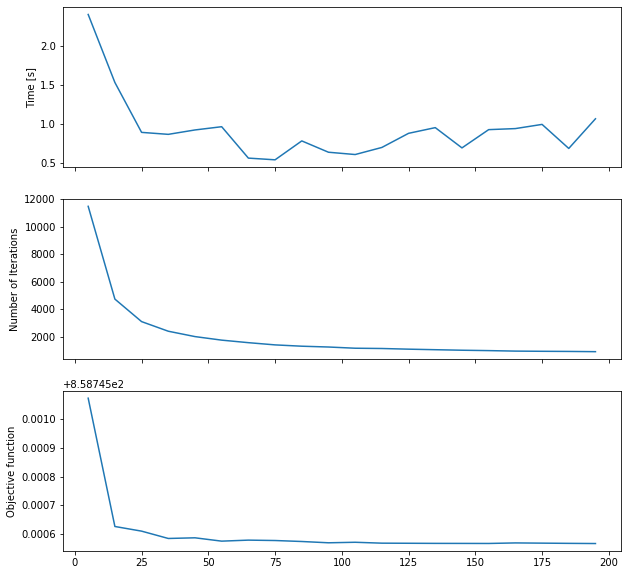

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(10,10))
ax1.plot(list(range(5,maxi,step)),time_ellapsed) 
ax1.set_ylabel('Time [s]')
ax2.plot(list(range(5,maxi,step)),iterations) 
ax2.set_ylabel('Number of Iterations')
ax3.plot(list(range(5,maxi,step)),obj_fun) 
ax3.set_ylabel('Objective function')

From the graphs we can see that the optimal batch size is to choose all of the columns of the matrix at the same time (batch size = number of predictors), which actually translates to the normal gradient descent method. 

Although it is not very clear since the variation of the results are high, we can observe an increasing trend after the batch size passes batch = 100. And what we can see very clearly is that for values lower than 50 the time and the iterations number is very long. 

If we were to choose only one attribute (k=1), then we go back to the case of the coordinate descent, which we can observe to be the least efficient one.

It is iteresting to note that we can even choose a batch size larger than the number of coefficients, but this does not translate into a faster convergence. Although the objective function reaches a plateau and does not get any smaller. 

Maybe in the case of having thousends of coefficients ($\beta_p$) we could expect to see the increase of the bacth size translated into more computation time, and thus lower efficiency. But in our example, we see that the number of parameters is not big enough to consider these kinds of techniques.

**Mini-batch gradient with momentum**

The mini-batch gradient descent with momentum adds speed to the last iterations, when the algorithm is getting closer to the solution, since it considers the last iteration's gradient value.

In [44]:
def momentum_batch(alpha=1e-5, n_iter= 50000, tol=100, eps=1e-4, batch = 100, eta = 0.8):

    # initializing values
    (a,b)=X.shape
    beta_mbatch = np.zeros(b)
    OF_iter = np.zeros(n_iter)
    tol_iterMB = np.zeros(n_iter)
    
    start = time.time()
    
    i = 0
    gradk = 0
    while (i <= n_iter-2) and (tol > eps):
        i=i+1
        
        # randomly selecting the index to choose for the method
        k = np.random.randint(0,b,batch)
        gradk = gradient_coord(beta_mbatch,k,X,Y, rho) + eta*gradk
        
        beta_mbatch = beta_mbatch - gradk * alpha
        tol = LA.norm(gradk, ord = 2)
        
        OF_iter[i] = least_sq_ridge(beta_mbatch, X, Y, rho)
        tol_iterMB[i] = tol
    
    momentum_batch_time = time.time()-start
    momentum_batch_iterations = i
    
    return momentum_batch_time, OF_iter[i], tol_iterMB[i], beta_mbatch, momentum_batch_iterations  

In [45]:
momentum_batch_time, ObjectiveF, Tolerance, beta_mbatch, momentum_batch_iterations  = momentum_batch(alpha=1e-5, n_iter= 50000, tol=100, eps=1e-4, batch = 50, eta = 0.1)

In [46]:
momentum_batch_sum = {'time': momentum_batch_time, 'iterations': momentum_batch_iterations, 'error': error_value(beta_mbatch),
              'objective function': ObjectiveF, "last iteration's tol": Tolerance  }
momentum_batch_sum

{'time': 0.7195923328399658,
 'iterations': 1540,
 'error': 5.849826107888017e-07,
 'objective function': 858.7456379727515,
 "last iteration's tol": 8.914436965045366e-05}

Below we can see a summary table with all the recorded parameters from the three different methods studied in section d.)

In [47]:
summary_d = {'Coordinate Descent': coord_grad_sum, 'Mini-Batch Descent': mini_batch_sum, 'Momentum-Batch Descent': momentum_batch_sum }
pd.DataFrame.from_dict(summary_d).round(5)

,Coordinate Descent,Mini-Batch Descent,Momentum-Batch Descent
time,0.65003,0.56995,0.71959
iterations,3732.00000,1692.00000,1540.00000
error,0.03502,0.00000,0.00000
objective function,1825.34802,858.74560,858.74564
last iteration's tol,0.00009,0.00009,0.00009


We can see that the  mini-batch  is the fastest of these, and the one that requires the lowest iterations is the mini-batch with momentum. Both the Mini-Batch without and with momentum approach very much to the objective function value obtained with the analytical solution. 

The Mini-Batch Descent with batch-size = 1 becomes simply the Coordinate Descent, and when the batch size becomes equal to the size of the parameters, this is just the normal gradient descent. 

We can see that the momentum efficiently helps the algorithm to get faster to the solution since it takes into consideration the last iteration's result. But in the contrary, we must now take into consideration the parameter $\eta$ that will have an influence in the total number of iterations we will obtain. 

### Conclusion

To conclude, we have shown through the report different kinds of solvers and methods to reach an optimum value, in this case minimize the ridge regression equation in order to approximate the coefficients to their treu values. 

We have seen that there are some very fast methods but more computationally expensive, like the newton's method. And there are other methods which are computationally simpler but take longer time to reach a convergence value, like for example the coordinate descent method. 

We must always keep in mind the type of problem we are facing to choose the better solver, since if we are dealing with a small sample size, and it will not be that computationally heavy to perform, we could confortably pick the newton's method. But if we're working with big data sets, the most suitable option would be to pick the mini-batch descent method. 

Overall, this assignment has helped understand and comprehend the different kinds of algortihms to minimize or maximize a certain function and that they could be applied to thausends of applications in every field.